In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.multinomial import Multinomial
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sys
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import log_sum_exp
from util_hmm_pytorch import *
from gmm_dataset import *
import numpy as np

output_notebook()

Loading BokehJS ...

In [2]:
# K = 3
# N = 500
# D = 2
# Y = sampling()
# plot_samples(Y)
# Y = torch.from_numpy(Y)

T = 500
dt = 1
init_state = np.random.random(4) * 8
# init_state = np.array([0,0,0.2,-0.1])
Y, A_true, STATE = generate_data(T, dt, init_state)
Y = torch.from_numpy(Y)
N, D = Y.shape

In [3]:
K = 12
## prior
alpha_init_0 = torch.ones(K).double()
# L = torch.ones((K, K))  / (2 *(K-1))
# alpha_trans_0 = torch.cat((torch.cat((torch.eye(4)*0.5, torch.ones((4, K-4)) * (0.5 / (K-4))), 1),\
# torch.ones((K-4, K)) * (1.0 / K)), 0).double()
alpha_trans_0 = torch.ones((K, K)).double()
m_0 = Y.mean(0)
beta_0 = 1.0
nu_0 = 3.1
W_0 =  (nu_0-D-1) * torch.mm((Y - m_0).transpose(0,1), (Y - m_0)) / (N)
cov = torch.from_numpy(np.cov(Y.transpose(0,1)))
## plot transition prior
# a = alpha_trans_0.data.numpy()
# plt.imshow(a)
# plt.colorbar()

In [4]:
alpha_init_hat = alpha_init_0
alpha_trans_hat = alpha_trans_0
m = MultivariateNormal(m_0, cov)
m_ks = m.sample((K,))
beta_ks = (torch.ones(K) * beta_0).double()
nu_ks = (torch.ones(K) * nu_0).double()
W_ks = W_0.repeat(K, 1, 1)
# cov_ks = np.tile(cov,(K,1,1)) 

In [5]:
iterations = 100

In [6]:
epoch_elbos = []
for i in range(iterations):
    ## VBE step
    log_gammas, log_eta = vbE_step(alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, Y, N, D, K)
    N_ks, Y_ks, S_ks = stats(log_gammas, Y, D, K)
    ## VBM step
    alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, cov_ks = vbM_step(log_eta, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, N, D, K)
#     ## elbokl_niw(nu_0, W_0, nu_ks, W_ks, D, K)
    epoch_elbo = elbo(log_gammas, log_eta, alpha_init_0, alpha_trans_0, nu_0, W_0, m_0, beta_0, N_ks, Y_ks, S_ks, alpha_init_hat, alpha_trans_hat, nu_ks, W_ks, m_ks, beta_ks, Y, N, D, K)
    epoch_elbos.append(epoch_elbo)
#     print('Iteration:%d, ELBO:%f' % ((i+1), epoch_elbo))
# # final_covs = cov_ks ## mean of inverse wishart
# # final_mus = m_ks ## mean of gaussian

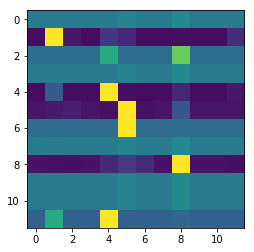

In [26]:
a = output_transition(alpha_trans_hat)
# fig=plt.figure(figsize=(8, 8))
# fig.add_subplot(1, 2, 1)
plt.imshow(a, cmap='viridis', vmin=0, vmax=0.2)
# fig.add_subplot(1, 2, 2)
# plt.imshow(A_true, cmap='viridis', vmin=0, vmax=1)

In [63]:
## sample from initial distribution
final_init_prob = alpha_init_hat / alpha_init_hat.sum()
init_obj = Multinomial(1, final_init_prob)
init_hidden = torch.nonzero(init_obj.sample()).item()
## transition matrix
A = (alpha_trans_hat.transpose(0,1) / alpha_trans_hat.sum(1)).transpose(0,1)

In [60]:
from probtorch.util import log_sum_exp
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
from bokeh.io import push_notebook, show, output_notebook
import time

In [9]:
# box_bound = np.array([-200, 200, -200, 200])
# plot = figure(plot_width=300, plot_height=300)
# plot.x_range = Range1d(box_bound[0], box_bound[1])
# plot.y_range = Range1d(box_bound[2], box_bound[3])
# # m_ks_np = m_ks.data.numpy()
# c = plot.circle(x=[init_state[0]], y=[init_state[1]])
# target = show(plot, notebook_handle=True)

In [10]:
# for t in range(T):
#     if t == 0:
#         new_pos = m_ks[init_hidden] + init_state[:2]
#         old_hidden = init_hidden
#     else:
#         new_hidden_obj = Multinomial(1, A[old_hidden])
#         new_hidden = torch.nonzero(new_hidden_obj.sample()).item()
#         new_pos += m_ks[new_hidden]
#         old_hidden = new_hidden
#     c.data_source.data['x'] = [new_pos[0]]
#     c.data_source.data['y'] = [new_pos[1]]
#     push_notebook(handle=target)
#     time.sleep(0.2)

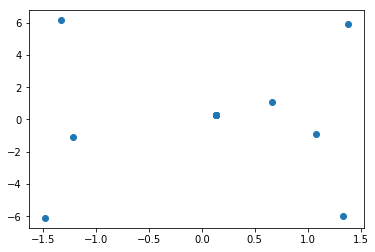

In [19]:
plt.scatter(m_ks[:,0], m_ks[:,1])

In [20]:
m_ks

tensor([[ 0.1325,  0.2969],
        [ 1.3317, -6.0021],
        [ 0.6661,  1.1086],
        [ 0.1325,  0.2969],
        [ 1.3761,  5.9365],
        [-1.4785, -6.0857],
        [-1.2171, -1.0974],
        [ 0.1325,  0.2969],
        [-1.3321,  6.1368],
        [ 0.1325,  0.2969],
        [ 0.1325,  0.2969],
        [ 1.0767, -0.8686]], dtype=torch.float64)